# Compare BBVI and MCMC for the california housing dataset

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os 

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate as tigerpyMVNDG

import liesel.model as lsl
import liesel.goose as gs
from liesel.distributions import MultivariateNormalDegenerate as lieselMVNDG
from liesel.goose.types import Array

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

# Load the data
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)
df = california_housing.frame

## Visual Data Analysis 

In [2]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


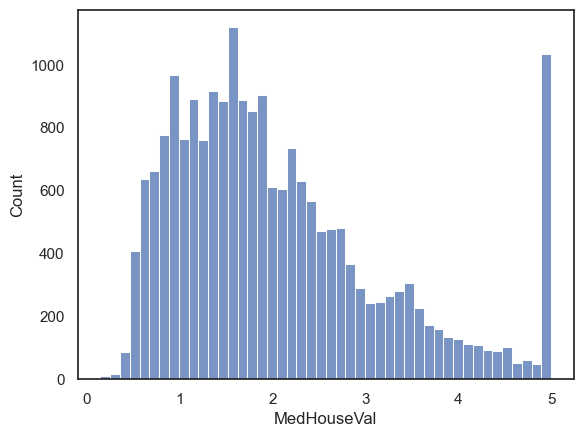

In [3]:
sns.set_theme(style="white")
sns.histplot(data=df, x="MedHouseVal")
plt.show()

In [4]:
cols = [col for col in df.columns if col not in ["MedHouseVal"]]

In [5]:
cols

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [6]:
if len(cols)%2 == 0:
    rows = len(cols)/2
else:
    rows = len(cols)/2 + 1

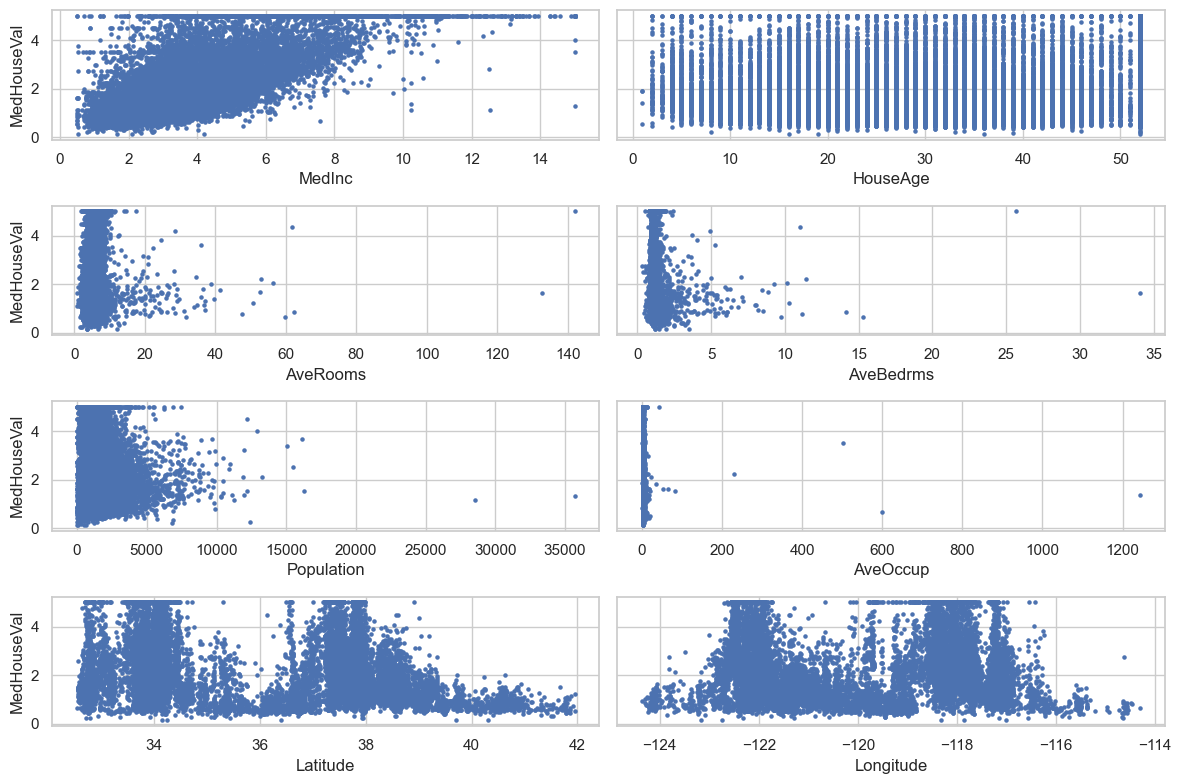

In [7]:
sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(nrows=int(rows), ncols=2, figsize=(12,8))

for col, ax in zip(cols, axs.flat):
    df.plot(kind="scatter", x=col, y="MedHouseVal", s=5, ax=ax, sharey=True)
plt.tight_layout()
plt.show()

In [8]:
# create log variables 
df["logMedInc"] = np.log(df["MedInc"])
df["logAveRooms"] = np.log(df["AveRooms"])
df["logAveBedrms"] = np.log(df["AveBedrms"])
df["logPopulation"] = np.log(df["Population"])
df["logAveOccup"] = np.log(df["AveOccup"])

In [9]:
cols = [col for col in df.columns if "log" in col]
if len(cols)%2 == 0:
    rows = len(cols)/2
else:
    rows = len(cols)/2 + 1

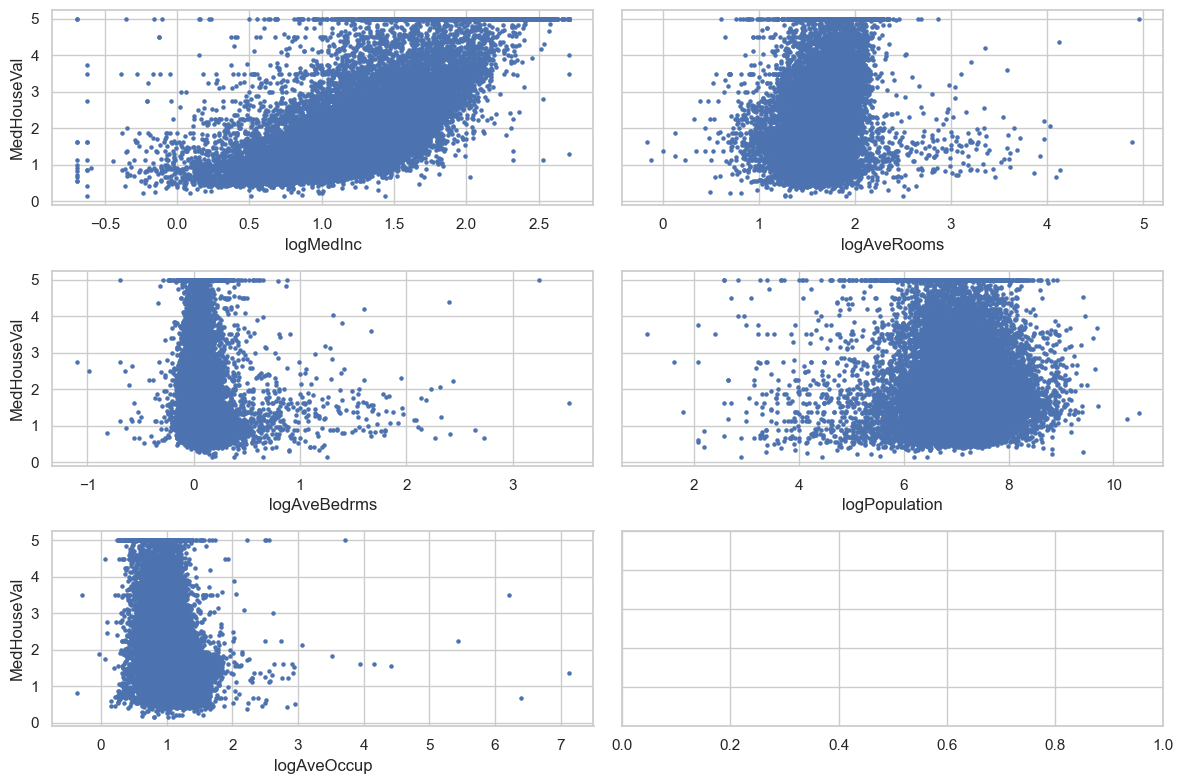

In [10]:
sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(nrows=int(rows), ncols=2, figsize=(12,8))

for i, col in enumerate(cols):
    df.plot(kind="scatter", x=col, y="MedHouseVal", s=5, ax=axs.flat[i], sharey=True)

plt.tight_layout()
plt.show()

In [12]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,logMedInc,logAveRooms,logAveBedrms,logPopulation,logAveOccup
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,2.119287,1.943640,0.023530,5.774552,0.938270
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,2.116424,1.830682,-0.028522,7.783641,0.746613
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,1.982022,2.114825,0.070874,6.206576,1.030426
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,1.730434,1.760845,0.070514,6.324359,0.935287
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,1.347086,1.837665,0.077962,6.336826,0.779998


## Fit Tigerpy 

In [13]:
# Define a model with intercept 
# Set up design matrix for loc
X = tiger.Obs(name="X", intercept=True)
X.fixed(data=df.loc[:,["logAveRooms", "logPopulation", "logAveOccup"]].to_numpy())
X.smooth(data=df["logMedInc"].to_numpy(), n_knots=20)
X.smooth(data=df["HouseAge"].to_numpy(), n_knots=20)
X.smooth(data=df["Latitude"].to_numpy(), n_knots=20)
X.smooth(data=df["Longitude"].to_numpy(), n_knots=20)
X.center()

# Set up design matrix for scale 
Z = tiger.Obs(name="Z", intercept=True)
Z.fixed(data=df.loc[:,["logAveRooms", "logPopulation", "logAveOccup"]].to_numpy())
Z.smooth(data=df["logMedInc"].to_numpy(), n_knots=20)
Z.smooth(data=df["HouseAge"].to_numpy(), n_knots=20)
Z.smooth(data=df["Latitude"].to_numpy(), n_knots=20)
Z.smooth(data=df["Longitude"].to_numpy(), n_knots=20)
Z.center()

In [14]:
# Linear Predictor for the location ----
# Fixed coefficents 
# Set up beta_fixed hyperparameters 
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.zeros((4,)), distribution=beta_dist, name="beta")

# Smooth coefficients 1: logMedIncome
# Set up hyperparameters for the beta_smooth_scale  
smooth1_tau2_a = tiger.Hyper(1.0, name="smooth1_tau2_a")
smooth1_tau2_b = tiger.Hyper(0.00005, name="smooth1_tau2_b")
smooth1_tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=smooth1_tau2_a, scale=smooth1_tau2_b)
smooth1_tau2 = tiger.Param(value=jnp.array([1.0]), distribution=smooth1_tau2_dist, param_space="positive", name="smooth1_tau2")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth1_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[0]), name="smooth1_loc")
smooth1_pen = tiger.Hyper(X.smooth_pen_mat_cent[0], name="smooth1_pen")
# Set up parameters
smooth1_dist = tiger.Dist(tigerpyMVNDG, loc=smooth1_loc, var=smooth1_tau2, pen=smooth1_pen)
smooth1 = tiger.Param(value=np.zeros(X.smooth_dim_cent[0]), distribution=smooth1_dist, name="smooth1")

# Smooth coefficients 2: HouseAge
# Set up hyperparameters for the beta_smooth_scale  
smooth2_tau2_a = tiger.Hyper(1.0, name="smooth2_tau2_a")
smooth2_tau2_b = tiger.Hyper(0.00005, name="smooth2_tau2_b")
smooth2_tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=smooth2_tau2_a, scale=smooth2_tau2_b)
smooth2_tau2 = tiger.Param(value=jnp.array([1.0]), distribution=smooth2_tau2_dist, param_space="positive", name="smooth2_tau2")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth2_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[1]), name="smooth2_loc")
smooth2_pen = tiger.Hyper(X.smooth_pen_mat_cent[1], name="smooth2_pen")
# Set up parameters
smooth2_dist = tiger.Dist(tigerpyMVNDG, loc=smooth2_loc, var=smooth2_tau2, pen=smooth2_pen)
smooth2 = tiger.Param(value=np.zeros(X.smooth_dim_cent[1]), distribution=smooth2_dist, name="smooth2")


# Smooth coefficients 3: Latitude
# Set up hyperparameters for the beta_smooth_scale  
smooth3_tau2_a = tiger.Hyper(1.0, name="smooth3_tau2_a")
smooth3_tau2_b = tiger.Hyper(0.00005, name="smooth3_tau2_b")
smooth3_tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=smooth3_tau2_a, scale=smooth3_tau2_b)
smooth3_tau2 = tiger.Param(value=jnp.array([1.0]), distribution=smooth3_tau2_dist, param_space="positive", name="smooth3_tau2")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth3_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[2]), name="smooth3_loc")
smooth3_pen = tiger.Hyper(X.smooth_pen_mat_cent[2], name="smooth3_pen")
# Set up parameters
smooth3_dist = tiger.Dist(tigerpyMVNDG, loc=smooth3_loc, var=smooth3_tau2, pen=smooth3_pen)
smooth3 = tiger.Param(value=np.zeros(X.smooth_dim_cent[2]), distribution=smooth3_dist, name="smooth3")

# Smooth coefficients 4: Longitude
# Set up hyperparameters for the beta_smooth_scale  
smooth4_tau2_a = tiger.Hyper(1.0, name="smooth4_tau2_a")
smooth4_tau2_b = tiger.Hyper(0.00005, name="smooth4_tau2_b")
smooth4_tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=smooth4_tau2_a, scale=smooth4_tau2_b)
smooth4_tau2 = tiger.Param(value=jnp.array([1.0]), distribution=smooth4_tau2_dist, param_space="positive", name="smooth4_tau2")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth4_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[3]), name="smooth4_loc")
smooth4_pen = tiger.Hyper(X.smooth_pen_mat_cent[3], name="smooth4_pen")
# Set up parameters
smooth4_dist = tiger.Dist(tigerpyMVNDG, loc=smooth4_loc, var=smooth4_tau2, pen=smooth4_pen)
smooth4 = tiger.Param(value=np.zeros(X.smooth_dim_cent[3]), distribution=smooth4_dist, name="smooth4")

# Set up the linear predictor
lpred_loc = tiger.Lpred(obs=X, 
                        function=jnp.exp,
                        beta=beta, 
                        smooth1=smooth1, 
                        smooth2=smooth2,
                        smooth3=smooth3,
                        smooth4=smooth4, 
                        name="loc")


In [15]:
# Linear Predictor for the scale ----
# Fixed coefficents 
# Set up beta_fixed hyperparameters 
gamma_loc = tiger.Hyper(0.0, name="gamma_loc")
gamma_scale = tiger.Hyper(3.0, name="gamma_scale")

# Set up parameters
gamma_dist = tiger.Dist(tfjd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = tiger.Param(value=np.zeros((4,)), distribution=gamma_dist, name="gamma")

# Smooth coefficients 5: logMedIncome
# Set up hyperparameters for the beta_smooth_scale  
smooth5_tau2_a = tiger.Hyper(1.0, name="smooth5_tau2_a")
smooth5_tau2_b = tiger.Hyper(0.00005, name="smooth5_tau2_b")
smooth5_tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=smooth5_tau2_a, scale=smooth5_tau2_b)
smooth5_tau2 = tiger.Param(value=jnp.array([1.0]), distribution=smooth5_tau2_dist, param_space="positive", name="smooth5_tau2")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth5_loc = tiger.Hyper(np.zeros(Z.smooth_dim_cent[0]), name="smooth5_loc")
smooth5_pen = tiger.Hyper(Z.smooth_pen_mat_cent[0], name="smooth5_pen")
# Set up parameters
smooth5_dist = tiger.Dist(tigerpyMVNDG, loc=smooth5_loc, var=smooth5_tau2, pen=smooth5_pen)
smooth5 = tiger.Param(value=np.zeros(Z.smooth_dim_cent[0]), distribution=smooth5_dist, name="smooth5")

# Smooth coefficients 6: HouseAge
# Set up hyperparameters for the beta_smooth_scale  
smooth6_tau2_a = tiger.Hyper(1.0, name="smooth6_tau2_a")
smooth6_tau2_b = tiger.Hyper(0.00005, name="smooth6_tau2_b")
smooth6_tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=smooth6_tau2_a, scale=smooth6_tau2_b)
smooth6_tau2 = tiger.Param(value=jnp.array([1.0]), distribution=smooth6_tau2_dist, param_space="positive", name="smooth6_tau2")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth6_loc = tiger.Hyper(np.zeros(Z.smooth_dim_cent[1]), name="smooth6_loc")
smooth6_pen = tiger.Hyper(Z.smooth_pen_mat_cent[1], name="smooth6_pen")
# Set up parameters
smooth6_dist = tiger.Dist(tigerpyMVNDG, loc=smooth6_loc, var=smooth6_tau2, pen=smooth6_pen)
smooth6 = tiger.Param(value=np.zeros(Z.smooth_dim_cent[1]), distribution=smooth6_dist, name="smooth6")

# Smooth coefficients 7: Latitude
# Set up hyperparameters for the beta_smooth_scale  
smooth7_tau2_a = tiger.Hyper(1.0, name="smooth7_tau2_a")
smooth7_tau2_b = tiger.Hyper(0.00005, name="smooth7_tau2_b")
smooth7_tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=smooth7_tau2_a, scale=smooth7_tau2_b)
smooth7_tau2 = tiger.Param(value=jnp.array([1.0]), distribution=smooth7_tau2_dist, param_space="positive", name="smooth7_tau2")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth7_loc = tiger.Hyper(np.zeros(Z.smooth_dim_cent[2]), name="smooth7_loc")
smooth7_pen = tiger.Hyper(Z.smooth_pen_mat_cent[2], name="smooth7_pen")
# Set up parameters
smooth7_dist = tiger.Dist(tigerpyMVNDG, loc=smooth7_loc, var=smooth7_tau2, pen=smooth7_pen)
smooth7 = tiger.Param(value=np.zeros(Z.smooth_dim_cent[2]), distribution=smooth7_dist, name="smooth7")

# Smooth coefficients 8: Longitude
# Set up hyperparameters for the beta_smooth_scale  
smooth8_tau2_a = tiger.Hyper(1.0, name="smooth8_tau2_a")
smooth8_tau2_b = tiger.Hyper(0.00005, name="smooth8_tau2_b")
smooth8_tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=smooth8_tau2_a, scale=smooth8_tau2_b)
smooth8_tau2 = tiger.Param(value=jnp.array([1.0]), distribution=smooth8_tau2_dist, param_space="positive", name="smooth8_tau2")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth8_loc = tiger.Hyper(np.zeros(Z.smooth_dim_cent[3]), name="smooth8_loc")
smooth8_pen = tiger.Hyper(Z.smooth_pen_mat_cent[3], name="smooth8_pen")
# Set up parameters
smooth8_dist = tiger.Dist(tigerpyMVNDG, loc=smooth8_loc, var=smooth8_tau2, pen=smooth8_pen)
smooth8 = tiger.Param(value=np.zeros(Z.smooth_dim_cent[3]), distribution=smooth8_dist, name="smooth8")

# ----
# Set up the linear predictor
lpred_scale = tiger.Lpred(obs=Z, 
                          function=jnp.exp,
                          gamma=gamma, 
                          smooth5=smooth5, 
                          smooth6=smooth6,
                          smooth7=smooth7,
                          smooth8=smooth8, 
                          name="scale")


In [16]:
alpha_fn = lambda l, s: l**2/s**2
calc_alpha = tiger.Calc(alpha_fn, l=lpred_loc, s=lpred_scale)

beta_fn = lambda l, s: l/s**2
calc_beta = tiger.Calc(beta_fn, l=lpred_loc, s=lpred_scale)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Gamma, concentration=calc_alpha, rate=calc_beta)
m = tiger.Model(response=df["MedHouseVal"].to_numpy(), distribution=response_dist)

In [17]:
m.log_prob

Array(-42923.21, dtype=float32)

In [18]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

## Inference with BBVI 

In [78]:
q = bbvi.Bbvi(graph=graph,
              pre_train=True)

In [127]:
key = jax.random.PRNGKey(800)
key, subkey = jax.random.split(key)

In [79]:
q.run_bbvi(key=subkey,
           learning_rate=0.0001,
           pre_train_learning_rate=0.01,
           grad_clip=1e-5,
           threshold=0.5,
           pre_train_threshold=0.1,
           batch_size=128,
           pre_train_batch_size=512,
           train_share=0.8,
           num_var_samples=64,
           chunk_size=25,
           epochs=250)

Start pre-training ...
Finished pre-training
Start optimization ...
Finished optimization


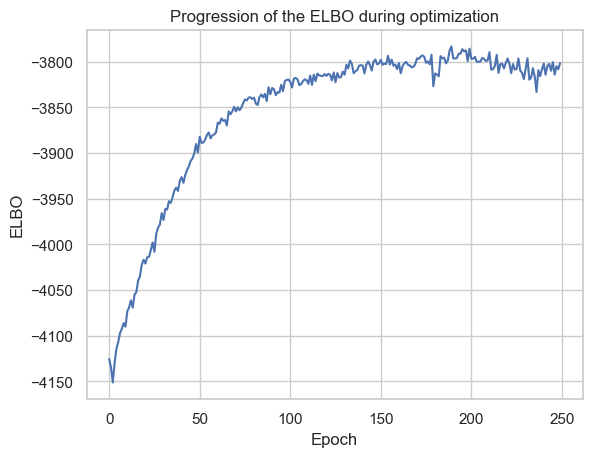

In [80]:
q.plot_elbo()

In [87]:
X.smooth_knots

[array([-0.6933472 , -0.54546007, -0.39757293, -0.2496858 , -0.10179867,
         0.04608847,  0.1939756 ,  0.34186273,  0.48974987,  0.637637  ,
         0.78552413,  0.93341127,  1.0812984 ,  1.22918553,  1.37707267,
         1.5249598 ,  1.67284693,  1.82073407,  1.9686212 ,  2.11650833,
         2.26439547,  2.4122826 ,  2.56016973,  2.70805687]),
 array([ 1.        ,  3.2173913 ,  5.43478261,  7.65217391,  9.86956522,
        12.08695652, 14.30434783, 16.52173913, 18.73913043, 20.95652174,
        23.17391304, 25.39130435, 27.60869565, 29.82608696, 32.04347826,
        34.26086957, 36.47826087, 38.69565217, 40.91304348, 43.13043478,
        45.34782609, 47.56521739, 49.7826087 , 52.        ]),
 array([32.54      , 32.94913043, 33.35826087, 33.7673913 , 34.17652174,
        34.58565217, 34.99478261, 35.40391304, 35.81304348, 36.22217391,
        36.63130435, 37.04043478, 37.44956522, 37.85869565, 38.26782609,
        38.67695652, 39.08608696, 39.49521739, 39.90434783, 40.31347826,


In [45]:
q.return_loc_params

{'beta': {'loc': Array([ 0.25954032,  0.21339008,  0.07221168, -0.47973385], dtype=float32)},
 'smooth1_tau2': {'loc': Array([0.22792263], dtype=float32)},
 'smooth2_tau2': {'loc': Array([0.4224391], dtype=float32)},
 'smooth3_tau2': {'loc': Array([0.1638058], dtype=float32)},
 'smooth4_tau2': {'loc': Array([0.16868646], dtype=float32)},
 'gamma': {'loc': Array([ 0.03474964,  0.12967247, -0.06490791, -0.40705723], dtype=float32)},
 'smooth5_tau2': {'loc': Array([0.19462082], dtype=float32)},
 'smooth6_tau2': {'loc': Array([0.21700019], dtype=float32)},
 'smooth7_tau2': {'loc': Array([0.18085214], dtype=float32)},
 'smooth8_tau2': {'loc': Array([0.32533088], dtype=float32)},
 'smooth1': {'loc': Array([-0.25662974, -0.17911044, -0.4389582 , -0.4627935 , -0.43277   ,
         -0.41816074, -0.3155093 , -0.22859038, -0.11782167, -0.0372443 ,
          0.06973796,  0.1209344 ,  0.20141882,  0.29991204,  0.4080271 ,
          0.5709322 ,  0.7045741 ,  0.61826134,  0.7036091 ], dtype=float32)}

## Set up model in liesel

In [120]:
# Define Groups for the smooth parameter priors
class VarianceIG(lsl.Group):
    def __init__(
        self, name: str, a: float, b: float, start_value: float = 1000.0
    ) -> None:
        a_var = lsl.Var(a, name=f"{name}_a")
        b_var = lsl.Var(b, name=f"{name}_b")

        prior = lsl.Dist(tfjd.InverseGamma, concentration=a_var, scale=b_var)
        tau2 = lsl.param(start_value, distribution=prior, name=name)
        super().__init__(name=name, a=a_var, b=b_var, tau2=tau2)

class SplineCoef(lsl.Group):
    def __init__(self, name: str, penalty: Array, tau2: lsl.param) -> None:
        penalty_var = lsl.Var(penalty, name=f"{name}_penalty")

        evals = jax.numpy.linalg.eigvalsh(penalty)
        rank = lsl.Data(jnp.sum(evals > 0.0), _name=f"{name}_rank")
        _log_pdet = jnp.log(jnp.where(evals > 0.0, evals, 1.0)).sum()
        log_pdet = lsl.Data(_log_pdet, _name=f"{name}_log_pdet")

        prior = lsl.Dist(
            lieselMVNDG.from_penalty,
            loc=0.0,
            var=tau2,
            pen=penalty_var,
            rank=rank,
            log_pdet=log_pdet
        )
        start_value = np.zeros(np.shape(penalty)[-1], np.float32)

        coef = lsl.param(start_value, distribution=prior, name=name)

        super().__init__(name, coef=coef, penalty=penalty_var, tau2=tau2, rank=rank)

class PSpline(lsl.Group):
    def __init__(
        self, name, basis_matrix: Array, penalty: Array, tau2_group: lsl.Group
    ) -> None:
        coef_group = SplineCoef(
            name=f"{name}_coef", penalty=penalty, tau2=tau2_group["tau2"]
        )

        basis_matrix = lsl.obs(basis_matrix, name=f"{name}_basis_matrix")
        smooth = lsl.Var(
            lsl.Calc(jnp.dot, basis_matrix, coef_group["coef"]), name=name
        )

        group_vars = coef_group.nodes_and_vars | tau2_group.nodes_and_vars

        super().__init__(
            name=name,
            basis_matrix=basis_matrix,
            smooth=smooth,
            **group_vars
        )

In [121]:
# Set up model in liesel
# Loc branch 
# Fixed parameter prior
beta_loc = lsl.Var(0.0, name="beta_loc")
beta_scale = lsl.Var(100.0, name="beta_scale")

# Set up the fixed parameters
beta_dist = lsl.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = lsl.param(value=jnp.zeros((4,)), distribution=beta_dist, name="beta")

# Set up the smooth parameters
# Smooth 1: logMedInc
tau2_group_1 = VarianceIG(name="tau2_smooth_1", a=1.0, b=0.00005)
penalty_group_1 = X.smooth_pen_mat_cent[0]
smooth_group_1 = PSpline(name="smooth_1", basis_matrix=X.design_mat_cent[1], penalty=penalty_group_1, tau2_group=tau2_group_1)

# Smooth 2: HouseAge
tau2_group_2 = VarianceIG(name="tau2_smooth_2", a=1.0, b=0.00005)
penalty_group_2 = X.smooth_pen_mat_cent[1]
smooth_group_2 = PSpline(name="smooth_2", basis_matrix=X.design_mat_cent[2], penalty=penalty_group_2, tau2_group=tau2_group_2)

# Smooth 3: Latitude
tau2_group_3 = VarianceIG(name="tau2_smooth_3", a=1.0, b=0.00005)
penalty_group_3 = X.smooth_pen_mat_cent[2]
smooth_group_3 = PSpline(name="smooth_3", basis_matrix=X.design_mat_cent[3], penalty=penalty_group_3, tau2_group=tau2_group_3)

# Smooth 4: Longitude
tau2_group_4 = VarianceIG(name="tau2_smooth_4", a=1.0, b=0.00005)
penalty_group_4 = X.smooth_pen_mat_cent[3]
smooth_group_4 = PSpline(name="smooth_4", basis_matrix=X.design_mat_cent[4], penalty=penalty_group_4, tau2_group=tau2_group_4)

X_liesel = lsl.obs(X.fixed_data, name="X")

lpred_loc_fn = lambda x, beta, smooth_1, smooth_2, smooth_3, smooth_4: jnp.dot(x, beta) + smooth_1 + smooth_2 + smooth_3 + smooth_4

lpred_loc_calc = lsl.Calc(lpred_loc_fn, 
                          x=X_liesel, 
                          beta=beta, 
                          smooth_1=smooth_group_1["smooth"], 
                          smooth_2=smooth_group_2["smooth"], 
                          smooth_3=smooth_group_3["smooth"], 
                          smooth_4=smooth_group_4["smooth"])

lpred_loc = lsl.Var(lpred_loc_calc, name="lpred_loc")

loc_fn = lambda l: jnp.exp(l)
loc_calc = lsl.Calc(loc_fn, s=lpred_loc)
loc = lsl.Var(loc_calc, name="loc")

In [122]:
# Scale branch 
# Fixed parameter prior
gamma_loc = lsl.Var(0.0, name="gamma_loc")
gamma_scale = lsl.Var(10.0, name="gamma_scale")

# Set up the fixed parameters
gamma_dist = lsl.Dist(tfjd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = lsl.param(value=jnp.zeros((4,)), distribution=gamma_dist, name="gamma")

Z_liesel = lsl.obs(Z.fixed_data, name="Z")

# Set up the smooth parameters
# Smooth 5: logMedInc
tau2_group_5 = VarianceIG(name="tau2_smooth_5", a=1.0, b=0.00005)
penalty_group_5 = X.smooth_pen_mat_cent[0]
smooth_group_5 = PSpline(name="smooth_5", basis_matrix=Z.design_mat_cent[1], penalty=penalty_group_5, tau2_group=tau2_group_5)

# Smooth 6: HouseAge
tau2_group_6 = VarianceIG(name="tau2_smooth_6", a=1.0, b=0.00005)
penalty_group_6 = X.smooth_pen_mat_cent[1]
smooth_group_6 = PSpline(name="smooth_6", basis_matrix=Z.design_mat_cent[2], penalty=penalty_group_6, tau2_group=tau2_group_6)

# Smooth 7: Latitude
tau2_group_7 = VarianceIG(name="tau2_smooth_7", a=1.0, b=0.00005)
penalty_group_7 = X.smooth_pen_mat_cent[2]
smooth_group_7 = PSpline(name="smooth_7", basis_matrix=Z.design_mat_cent[3], penalty=penalty_group_7, tau2_group=tau2_group_7)

# Smooth 8: Longitude
tau2_group_8 = VarianceIG(name="tau2_smooth_8", a=1.0, b=0.00005)
penalty_group_8 = X.smooth_pen_mat_cent[3]
smooth_group_8 = PSpline(name="smooth_8", basis_matrix=Z.design_mat_cent[4], penalty=penalty_group_8, tau2_group=tau2_group_8)

Z_liesel = lsl.obs(Z.fixed_data, name="Z")

lpred_scale_fn = lambda z, gamma, smooth_5, smooth_6, smooth_7, smooth_8: jnp.dot(z, gamma) + smooth_5 + smooth_6 + smooth_7 + smooth_8

lpred_scale_calc = lsl.Calc(lpred_scale_fn, 
                            z=Z_liesel, 
                            gamma=gamma, 
                            smooth_5=smooth_group_5["smooth"], 
                            smooth_6=smooth_group_6["smooth"], 
                            smooth_7=smooth_group_7["smooth"], 
                            smooth_8=smooth_group_8["smooth"])

lpred_scale = lsl.Var(lpred_scale_calc, name="lpred_scale")

scale_fn = lambda s: jnp.exp(s)
scale_calc = lsl.Calc(scale_fn, s=lpred_scale)
scale = lsl.Var(scale_calc, name="scale")

In [123]:
# Reparameterize the gamma distribution
alpha_fn = lambda l, s: l**2/s**2
alpha_calc = lsl.Calc(alpha_fn, l=lpred_loc, s=lpred_scale)
alpha_re = lsl.Var(alpha_calc, name="alpha_re")

beta_fn = lambda l, s: l/s**2
beta_calc = lsl.Calc(beta_fn, l=lpred_loc, s=lpred_scale)
beta_re = lsl.Var(beta_calc, name="beta_re")

In [124]:
response_dist = lsl.Dist(tfjd.Gamma, concentration=alpha_re, rate=beta_re)
response = lsl.Var(df["MedHouseVal"].to_numpy(), distribution=response_dist, name="response")

In [125]:
gb = lsl.GraphBuilder().add(response)
model = gb.build_model()

liesel.model.model - INFO - Converted dtype of Data(name="response_value").value
liesel.model.model - INFO - Converted dtype of Data(name="smooth_8_coef_penalty_value").value
liesel.model.model - INFO - Converted dtype of Data(name="smooth_7_coef_penalty_value").value
liesel.model.model - INFO - Converted dtype of Data(name="smooth_6_coef_penalty_value").value
liesel.model.model - INFO - Converted dtype of Data(name="smooth_5_coef_penalty_value").value
liesel.model.model - INFO - Converted dtype of Data(name="Z_value").value
liesel.model.model - INFO - Converted dtype of Data(name="smooth_4_coef_penalty_value").value
liesel.model.model - INFO - Converted dtype of Data(name="smooth_3_coef_penalty_value").value
liesel.model.model - INFO - Converted dtype of Data(name="smooth_2_coef_penalty_value").value
liesel.model.model - INFO - Converted dtype of Data(name="smooth_1_coef_penalty_value").value
liesel.model.model - INFO - Converted dtype of Data(name="X_value").value


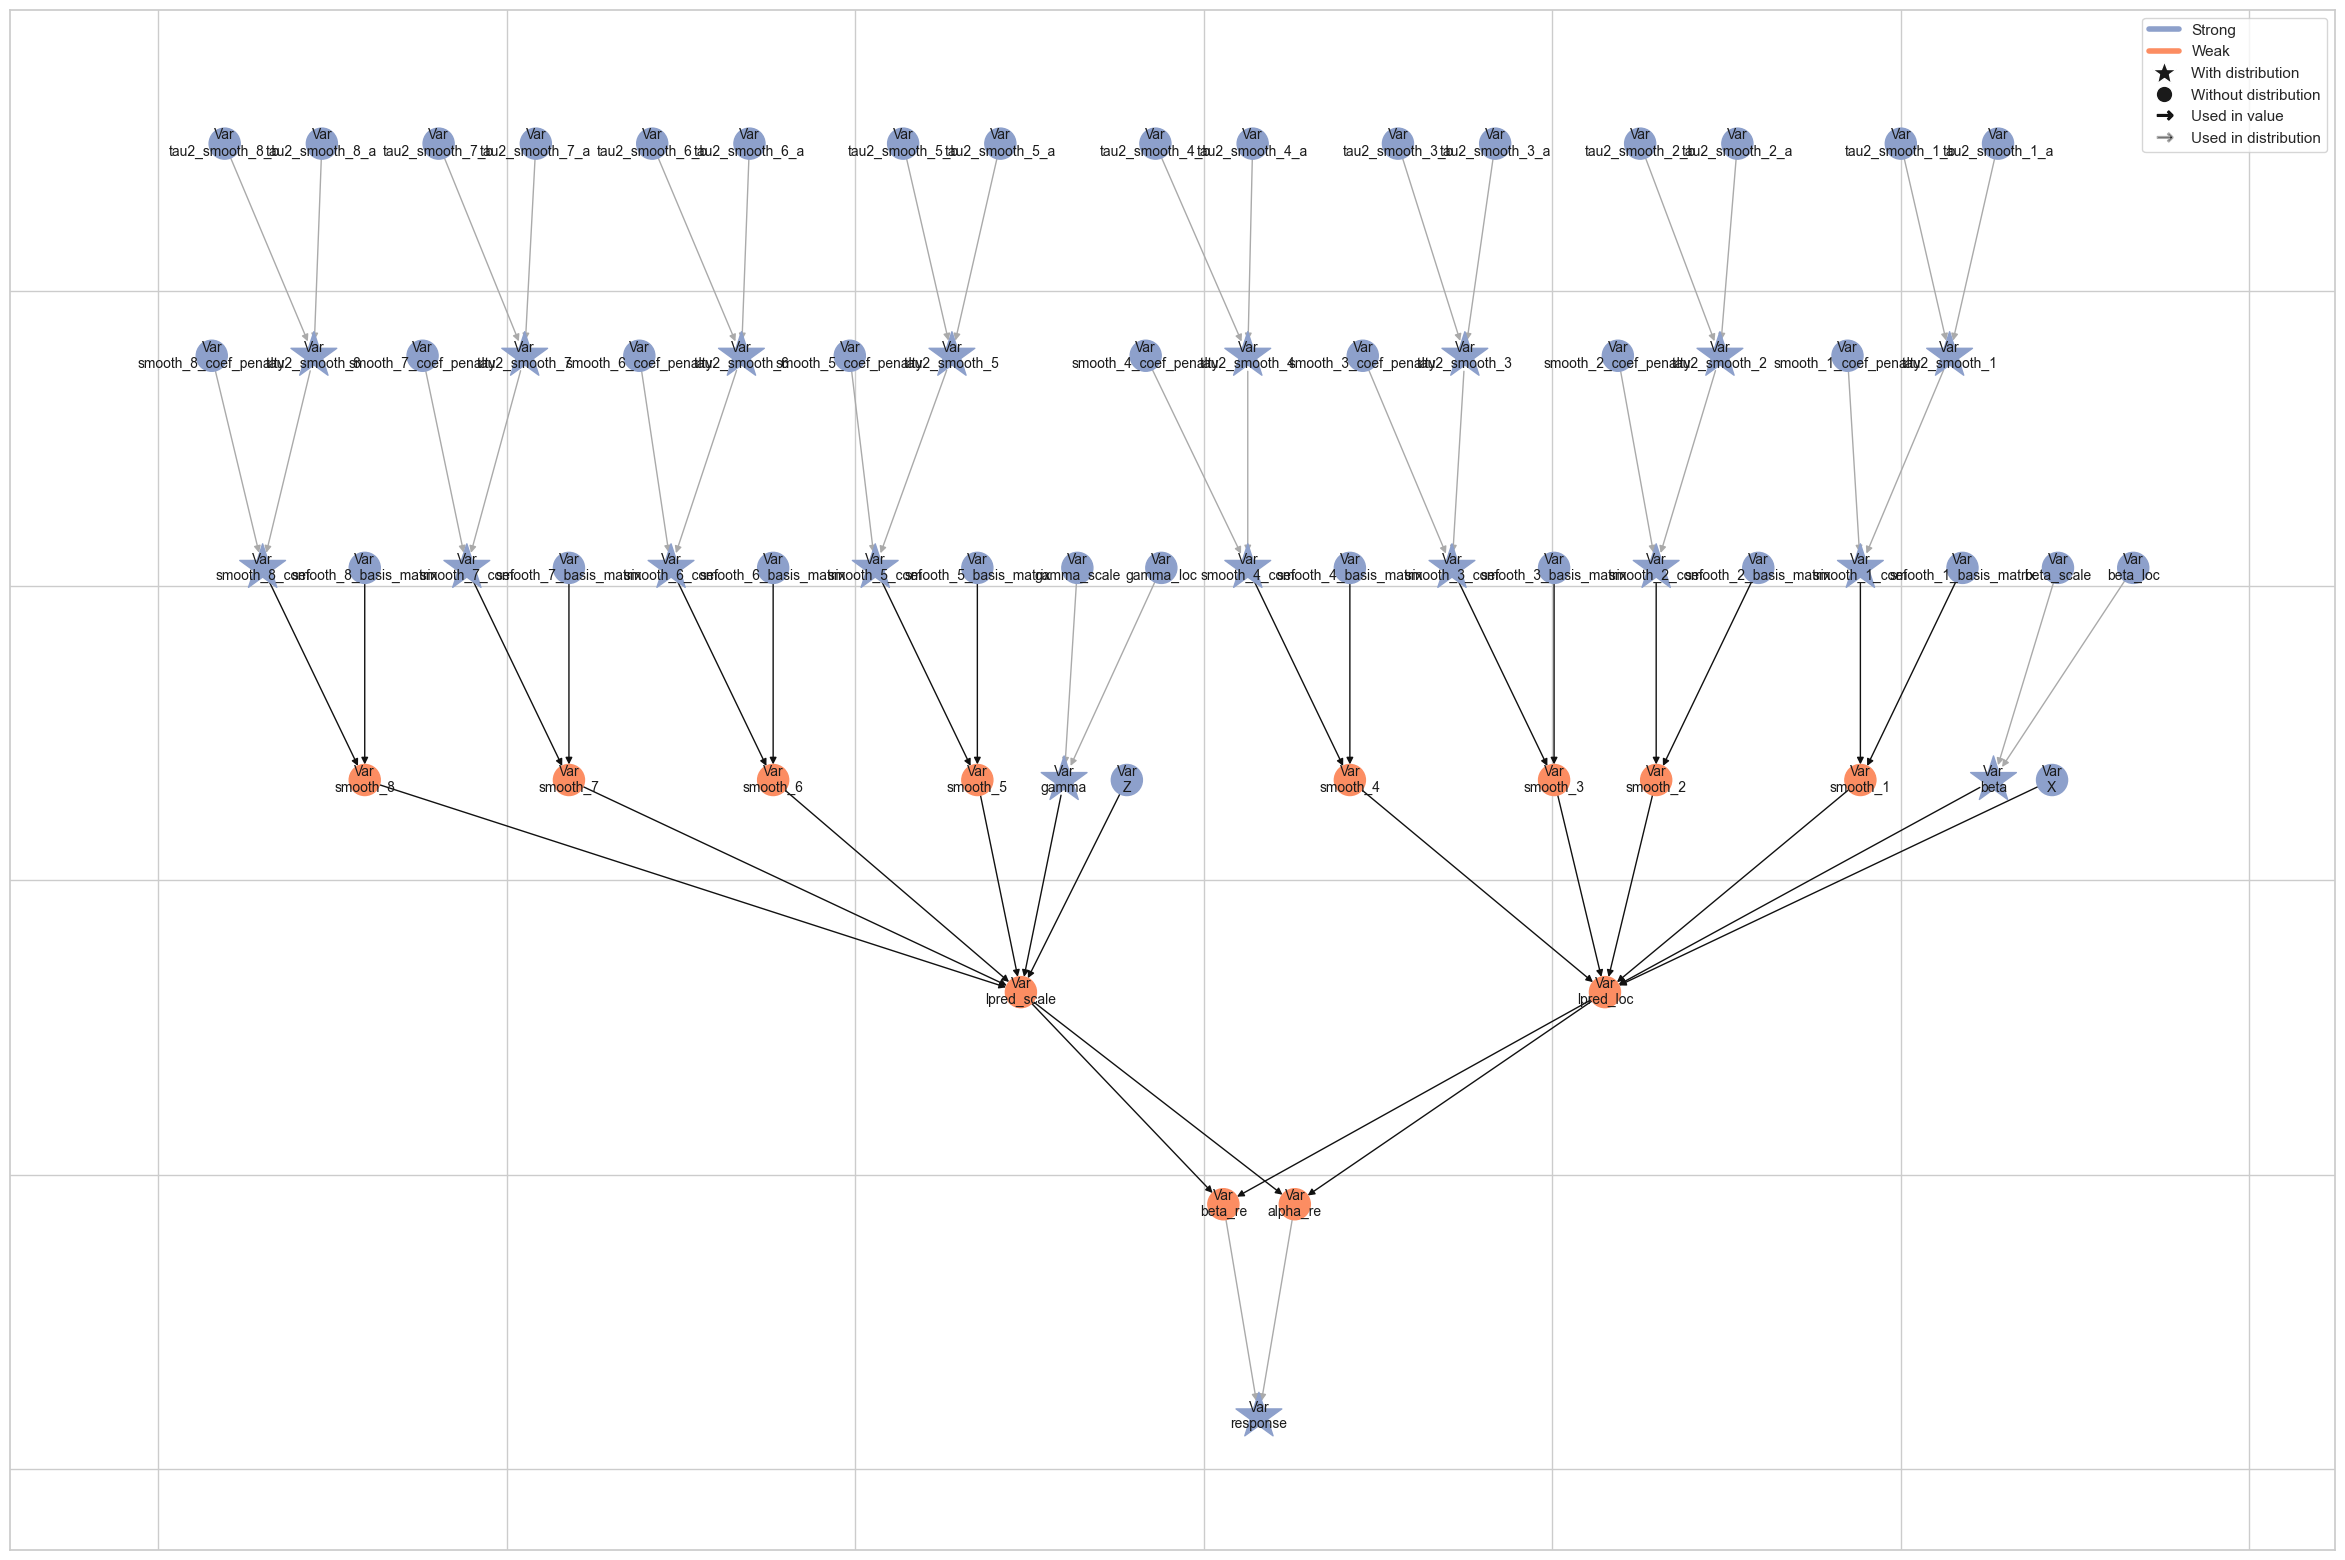

In [141]:
lsl.plot_vars(model, width=30, height=20)

In [129]:
def tau2_gibbs_kernel(p_spline: PSpline) -> gs.GibbsKernel:
    """Builds a Gibbs kernel for a smoothing parameter with an inverse gamma prior."""
    position_key = p_spline["tau2"].name

    def transition(prng_key, model_state):
        a_prior = p_spline.value_from(model_state, "a")
        b_prior = p_spline.value_from(model_state, "b")

        rank = p_spline.value_from(model_state, "rank")
        K = p_spline.value_from(model_state, "penalty")

        beta = p_spline.value_from(model_state, "coef")

        a_gibbs = jnp.squeeze(a_prior + 0.5 * rank)
        b_gibbs = jnp.squeeze(b_prior + 0.5 * (beta @ K @ beta))

        draw = b_gibbs / jax.random.gamma(prng_key, a_gibbs)

        return {position_key: draw}

    return gs.GibbsKernel([position_key], transition)

In [142]:
key, subkey = jax.random.split(key)
builder = gs.EngineBuilder(seed=subkey, num_chains=4)

builder.set_model(gs.LieselInterface(model))
builder.set_initial_values(model.state)

builder.add_kernel(gs.NUTSKernel(["beta"]))
builder.add_kernel(gs.NUTSKernel(["smooth_1_coef"]))
builder.add_kernel(gs.NUTSKernel(["smooth_2_coef"]))
builder.add_kernel(gs.NUTSKernel(["smooth_3_coef"]))
builder.add_kernel(gs.NUTSKernel(["smooth_4_coef"]))
builder.add_kernel(tau2_gibbs_kernel(smooth_group_1))
builder.add_kernel(tau2_gibbs_kernel(smooth_group_2))
builder.add_kernel(tau2_gibbs_kernel(smooth_group_3))
builder.add_kernel(tau2_gibbs_kernel(smooth_group_4))

builder.add_kernel(gs.NUTSKernel(["gamma"]))
builder.add_kernel(gs.NUTSKernel(["smooth_5_coef"]))
builder.add_kernel(gs.NUTSKernel(["smooth_6_coef"]))
builder.add_kernel(gs.NUTSKernel(["smooth_7_coef"]))
builder.add_kernel(gs.NUTSKernel(["smooth_8_coef"]))
builder.add_kernel(tau2_gibbs_kernel(smooth_group_5))
builder.add_kernel(tau2_gibbs_kernel(smooth_group_6))
builder.add_kernel(tau2_gibbs_kernel(smooth_group_7))
builder.add_kernel(tau2_gibbs_kernel(smooth_group_8))

builder.set_duration(warmup_duration=2000, posterior_duration=2000)

engine = builder.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [143]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 75, 75, 75, 75 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 75, 75, 75, 75 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 75, 75, 75, 75 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 75, 75, 75, 75 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 75, 75, 75, 75 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_09: 75, 75, 75, 75 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_10: 75, 75, 75, 75 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_11: 75, 75, 75, 75 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_12: 75, 75, 75, 75 / 75 transitions
liesel.goose.engine - WARNING - Errors 

In [139]:
results = engine.get_results()
gs.Summary(results)

/Users/SebLorek/anaconda3/envs/thesis/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Parameter summary:

                        kernel      mean        sd    q_0.05     q_0.5  \
parameter     index                                                      
beta          (0,)   kernel_00  0.000000  0.000000  0.000000  0.000000   
              (1,)   kernel_00  0.000000  0.000000  0.000000  0.000000   
              (2,)   kernel_00  0.000000  0.000000  0.000000  0.000000   
              (3,)   kernel_00  0.000000  0.000000  0.000000  0.000000   
gamma         (0,)   kernel_09  0.000000  0.000000  0.000000  0.000000   
...                        ...       ...       ...       ...       ...   
tau2_smooth_4 ()     kernel_08  0.000005  0.000002  0.000003  0.000005   
tau2_smooth_5 ()     kernel_14  0.000006  0.000002  0.000003  0.000005   
tau2_smooth_6 ()     kernel_15  0.000006  0.000002  0.000003  0.000005   
tau2_smooth_7 ()     kernel_16  0.000006  0.000002  0.000003  0.000005   
tau2_smooth_8 ()     kernel_17  0.000005  0.000002  0.000003  0.000005   

                       q_0.95  sample_size      ess_bulk      ess_tail  \
parameter     index                                                      
beta          (0,)   0.000000        80000  80000.000000  80000.000000   
              (1,)   0.000000        80000  80000.000000  80000.000000   
              (2,)   0.000000        80000  80000.000000  80000.000000   
              (3,)   0.000000        80000  80000.000000  80000.000000   
gamma         (0,)   0.000000        80000  80000.000000  80000.000000   
...                       ...          ...           ...           ...   
tau2_smooth_4 ()     0.000009        80000  80857.552196  79417.697668   
tau2_smooth_5 ()     0.000009        80000  77705.463417  79077.134175   
tau2_smooth_6 ()     0.000009        80000  76514.566054  78694.999389   
tau2_smooth_7 ()     0.000009        80000  78888.787801  80190.155729   
tau2_smooth_8 ()     0.000009        80000  78101.596720  78862.959897   

                         rhat  
parameter     index            
beta          (0,)        NaN  
              (1,)        NaN  
              (2,)        NaN  
              (3,)        NaN  
gamma         (0,)        NaN  
...                       ...  
tau2_smooth_4 ()     1.000009  
tau2_smooth_5 ()     1.000039  
tau2_smooth_6 ()     1.000007  
tau2_smooth_7 ()     0.999992  
tau2_smooth_8 ()     1.000104  

[168 rows x 10 columns]

Error summary:

                                                    count relative
kernel    error_code error_msg           phase                    
kernel_00 90         nan acceptance prob warmup     80000      1.0
                                         posterior  80000      1.0
kernel_01 90         nan acceptance prob warmup     80000      1.0
                                         posterior  80000      1.0
kernel_02 90         nan acceptance prob warmup     80000      1.0
                                         posterior  80000      1.0
kernel_03 90         nan acceptance prob warmup     80000      1.0
                                         posterior  80000      1.0
kernel_04 90         nan acceptance prob warmup     80000      1.0
                                         posterior  80000      1.0
kernel_09 90         nan acceptance prob warmup     80000      1.0
                                         posterior  80000      1.0
kernel_10 90         nan acceptance prob warmup     80000      1.0
                                         posterior  80000      1.0
kernel_11 90         nan acceptance prob warmup     80000      1.0
                                         posterior  80000      1.0
kernel_12 90         nan acceptance prob warmup     80000      1.0
                                         posterior  80000      1.0
kernel_13 90         nan acceptance prob warmup     80000      1.0
                                         posterior  80000      1.0

/Users/SebLorek/anaconda3/envs/thesis/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/SebLorek/anaconda3/envs/thesis/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


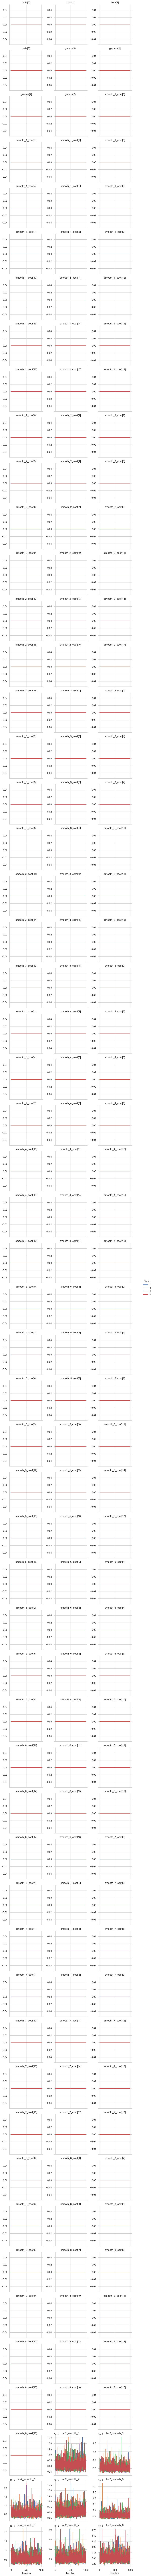

In [133]:
g = gs.plot_trace(results)

In [ ]:
p = gs.Summary(results).quantities